<a href="https://colab.research.google.com/github/pharringtonp19/mecon/blob/main/notebooks/Adverse_Selection_in_Health_Insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#@title Imports { display-mode: "form" }
%%capture 
!pip install jaxopt

import jax 
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp 
import jaxopt
from functools import partial 
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [15]:
#@title Inverse { display-mode: "form" }
def inverse(f):

  def inverse_fn(y):
    
    def closure(x,y):
      return (f(x)-y)**2

    solver = jaxopt.GradientDescent(fun=closure, maxiter=2000)
    res = solver.run(jnp.ones(shape=()), y)
    return res.params

  return inverse_fn

In [29]:
#@title Value Related Functions { display-mode: "form" }
def value(p, xs, u):
  return p*u(xs[0]) + (1-p)*u(xs[1])

def wtp_insurance(p, w0, xs, u):
  """Wealth is an argnument to this function"""
  zs = jnp.array([w0 + xs[0], w0 + xs[1]]) 
  return w0 - inverse(u)(value(p, zs, u)) # Risk Premium

Let's assume that we have a population of individuals who differ in the probability that they will be involved in a significant physical accident within the next year which would cost them $10,000. 

$$\textrm{Probability_of_accident} \sim U[.01, 0.99] $$

For the moment, let's assume that every person has the same preferences and the same initial wealth ($w_0$).

$$x \longmapsto u(x) = \sqrt{x}, \quad w_0 = \$15,000$$.

Then, assuming that everyone knows their own probabilty of an accident we can plot their willingness to pay for health insurance. 



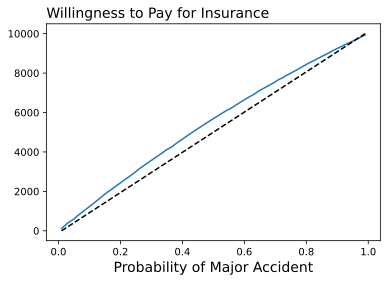

In [30]:
#@title Willingness to Pay { display-mode: "form" }
ps = jnp.linspace(0.01, 0.99, 100)
xs = jnp.array([-10000,0.])
f_temp = partial(wtp_insurance, w0=15000, xs=xs, u=lambda x: jnp.sqrt(x))
plt.plot(ps, jax.vmap(f_temp)(ps))
plt.plot(ps, jnp.linspace(0, 10000, 100), color='black', linestyle='--')
plt.title('Willingness to Pay for Insurance', size=14, loc='left')
plt.xlabel('Probability of Major Accident', size=14)
plt.show()

In [60]:
def insurer_price(p_min):
  insur_temp = partial(value, xs=xs, u=lambda x: x)
  expected_cost = jnp.mean(jax.vmap(insur_temp)(jnp.linspace(p_min, .99, 100)))
  return -expected_cost 

def min_probability(subsidy, cost):
  ps = jnp.linspace(0.01, 0.99, 100)
  f_temp = partial(wtp_insurance, w0=15000, xs=xs, u=lambda x: jnp.sqrt(x))
  wtp = jax.vmap(f_temp)(ps) + subsidy
  wtp_alt = jnp.where(wtp>cost, wtp, 10000)
  return ps[jnp.argmin(wtp_alt)]

In [62]:
p =.01 
for i in range(15):
  cost = insurer_price(p)
  print(f"Epoch:  {i:2d} | Minimum Accident Probability: {p:.2f} | Price of Plan: {cost:.0f}")
  p = partial(min_probability, 0.)(cost)

Epoch:   0 | Minimum Accident Probability: 0.01 | Price of Plan: 5000
Epoch:   1 | Minimum Accident Probability: 0.44 | Price of Plan: 7128
Epoch:   2 | Minimum Accident Probability: 0.65 | Price of Plan: 8217
Epoch:   3 | Minimum Accident Probability: 0.78 | Price of Plan: 8861
Epoch:   4 | Minimum Accident Probability: 0.86 | Price of Plan: 9257
Epoch:   5 | Minimum Accident Probability: 0.91 | Price of Plan: 9504
Epoch:   6 | Minimum Accident Probability: 0.94 | Price of Plan: 9653
Epoch:   7 | Minimum Accident Probability: 0.96 | Price of Plan: 9752
Epoch:   8 | Minimum Accident Probability: 0.97 | Price of Plan: 9801
Epoch:   9 | Minimum Accident Probability: 0.98 | Price of Plan: 9851
Epoch:  10 | Minimum Accident Probability: 0.98 | Price of Plan: 9851
Epoch:  11 | Minimum Accident Probability: 0.98 | Price of Plan: 9851
Epoch:  12 | Minimum Accident Probability: 0.98 | Price of Plan: 9851
Epoch:  13 | Minimum Accident Probability: 0.98 | Price of Plan: 9851
Epoch:  14 | Minimum

In [67]:
p =.01 
subsidy = insurer_price(p) -  wtp_insurance(p=0.01, w0=15000, xs=xs, u=lambda x: jnp.sqrt(x)) + 1.
for i in range(15):
  cost = insurer_price(p)
  print(f"Epoch:  {i:2d} | Minimum Accident Probability: {p:.2f} | Price of Plan: {cost:.0f}")
  p = partial(min_probability, subsidy)(cost)

Epoch:   0 | Minimum Accident Probability: 0.01 | Price of Plan: 5000
Epoch:   1 | Minimum Accident Probability: 0.01 | Price of Plan: 5000
Epoch:   2 | Minimum Accident Probability: 0.01 | Price of Plan: 5000
Epoch:   3 | Minimum Accident Probability: 0.01 | Price of Plan: 5000
Epoch:   4 | Minimum Accident Probability: 0.01 | Price of Plan: 5000
Epoch:   5 | Minimum Accident Probability: 0.01 | Price of Plan: 5000
Epoch:   6 | Minimum Accident Probability: 0.01 | Price of Plan: 5000
Epoch:   7 | Minimum Accident Probability: 0.01 | Price of Plan: 5000
Epoch:   8 | Minimum Accident Probability: 0.01 | Price of Plan: 5000
Epoch:   9 | Minimum Accident Probability: 0.01 | Price of Plan: 5000
Epoch:  10 | Minimum Accident Probability: 0.01 | Price of Plan: 5000
Epoch:  11 | Minimum Accident Probability: 0.01 | Price of Plan: 5000
Epoch:  12 | Minimum Accident Probability: 0.01 | Price of Plan: 5000
Epoch:  13 | Minimum Accident Probability: 0.01 | Price of Plan: 5000
Epoch:  14 | Minimum